使用pythorch加速运算的lowrankSNN

In [14]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.distributions as dist
from functions import Draw_Output, Draw_Conductance, Draw_RasterPlot, Draw_Voltage, Draw_Projection, save_model, load_config_yaml
from lowranksnn import LowRankSNN

In [15]:
# Read the configuration file
# config = load_config_yaml('config.yaml')
config = load_config_yaml('config_ING.yaml')

N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
P_EE = config['P_EE']
P_EI = config['P_EI']
P_IE = config['P_IE']
P_II = config['P_II']
factor_mn = config['factor_mn'] # 组合成conn时乘在lowrank matrix上的常數
RS = config['RandomStrength'] # 组合成conn时乘在random matrix上的常數

taud_E = config['taud_E']
taud_I = config['taud_I']
ratio_fast = config['ratio_fast']
if type(taud_E) == list: # introduce fast and slow time constants
    mask_tauE = torch.rand(1, N_E) < ratio_fast
    mask_tauI = torch.rand(1, N_I) < ratio_fast
    tau_E = torch.ones(1, N_E) * taud_E[1]
    tau_E[mask_tauE] = taud_E[0]
    tau_I = torch.ones(1, N_I) * taud_I[1]
    tau_I[mask_tauI] = taud_I[0]
    taud_E = tau_E.tolist()
    taud_I = tau_I.tolist()


mu = config['mu']
si = config['sigma']

mu_rand = config['mu_rand']
si_rand = config['sigma_rand']

dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)

color_Go = config['color_Go']
color_Nogo = config['color_Nogo']


m norm: tensor(1.0000)
n norm: tensor(1.)
Sti_nogo norm: tensor(1.)


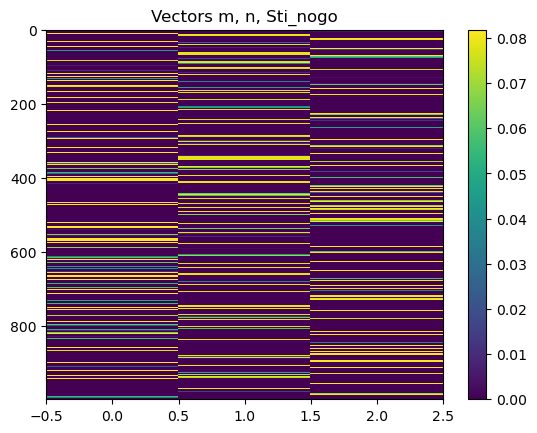

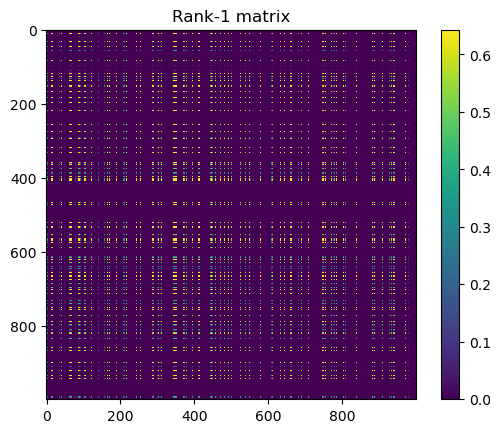

a_EE, b_EE, average value: tensor(0.5176) tensor(5.8987) tensor(0.0807)
a_EI, b_EI, average value: tensor(0.5407) tensor(6.0207) tensor(0.0824)
a_IE, b_IE, average value: tensor(0.0706) tensor(2.0903) tensor(0.0327)
a_II, b_II, average value: tensor(2.5846) tensor(11.4444) tensor(0.1842)
矩阵的秩: 997
非零元素的比例: 1.0


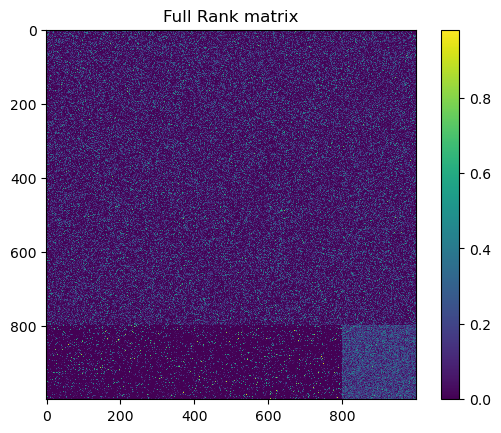

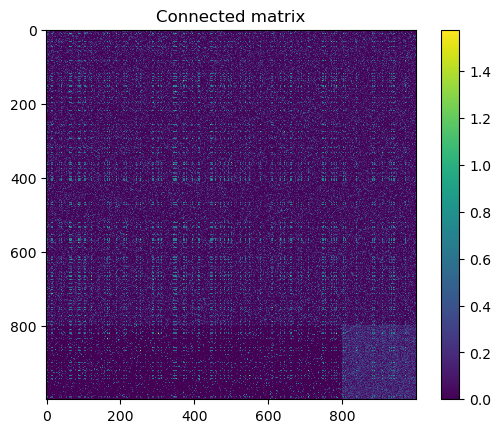

Connectivity matrix average value_EtoE: tensor(0.1001)
Connectivity matrix average value_EtoI: tensor(0.1001)
Connectivity matrix average value_ItoE: tensor(0.0502)
Connectivity matrix average value_ItoI: tensor(0.1995)


In [16]:
# Functions
def Generate_Vectors(N, mu=0.1, sigma=0.1):
    # Construct non-negative, orthogonal vectors m, n, Sti_nogo (sampled from beta distribution)
    # make sure the vectors have the same norm
    # vectors m, n, Sti_nogo are all in the length of N (size: N,1), while occupy different dimensions
    m = torch.zeros(N, 1)
    n = torch.zeros(N, 1)
    Sti_nogo = torch.zeros(N, 1)
    temp = torch.rand(N, 1)
    mask_m = temp < 0.33
    mask_n = (temp >= 0.33) & (temp < 0.66)
    mask_Sti_nogo = temp >= 0.66
    # generate vectors m, n, Sti_nogo
    m[mask_m] = dist.Beta(mu, sigma).sample((sum(mask_m), 1)).squeeze()
    n[mask_n] = dist.Beta(mu, sigma).sample((sum(mask_n), 1)).squeeze()
    Sti_nogo[mask_Sti_nogo] = dist.Beta(mu, sigma).sample((sum(mask_Sti_nogo), 1)).squeeze()
    # normalize the vectors
    m = m / torch.norm(m)
    n = n / torch.norm(n)
    Sti_nogo = Sti_nogo / torch.norm(Sti_nogo)
    return m, n, Sti_nogo

# test
m, n, Sti_nogo = Generate_Vectors(N)
# print("m:", m)
# print("n:", n)
# print("W_out:", W_out)
print("m norm:", torch.norm(m))
print("n norm:", torch.norm(n))
print("Sti_nogo norm:", torch.norm(Sti_nogo))
# draw the vectors m, n, Sti_nogo in heatmap
plt.figure()
plt.imshow(torch.cat((m, n, Sti_nogo), 1), aspect='auto',interpolation='nearest')
plt.colorbar()
plt.title('Vectors m, n, Sti_nogo')
plt.show()

W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))
#draw the rank-1 matrix
plt.figure()
plt.imshow(W_rank1,interpolation='nearest')
plt.colorbar()
plt.title('Rank-1 matrix')
plt.show()



def Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma=0.1):
    # Construct random weight matrix
    # use beta distribution to generate random matrix
    # W_rank1: low rank matrix
    # deside the average value of the beta distribution according to the rank-1 matrix to make sure
    # the average value of the sum of the rank-1 matrix and the random matrix is according to the P_EE, P_EI, P_IE, P_II
    N = N_E + N_I
    W = torch.zeros(N, N)

    mu_EE = P_EE - torch.sum(W_rank1[:N_E, :N_E]) / (N_E * N_E)
    mu_EI = P_EI - torch.sum(W_rank1[:N_E, N_E:]) / (N_E * N_I)
    mu_IE = P_IE - torch.sum(W_rank1[N_E:, :N_E]) / (N_I * N_E)
    mu_II = P_II - torch.sum(W_rank1[N_E:, N_E:]) / (N_I * N_I)

    # 生成a,b参数
    # 打印出来看看
    a_EE, b_EE = ab_beta(mu_EE, sigma)
    a_EI, b_EI = ab_beta(mu_EI, sigma)
    a_IE, b_IE = ab_beta(mu_IE, sigma)
    a_II, b_II = ab_beta(mu_II, sigma)

    print("a_EE, b_EE, average value:", a_EE, b_EE, mu_EE)
    print("a_EI, b_EI, average value:", a_EI, b_EI, mu_EI)
    print("a_IE, b_IE, average value:", a_IE, b_IE, mu_IE)
    print("a_II, b_II, average value:", a_II, b_II, mu_II)

    # 生成连接矩阵
    W[:N_E, :N_E] = dist.Beta(a_EE, b_EE).sample((N_E, N_E))
    W[:N_E, N_E:] = dist.Beta(a_EI, b_EI).sample((N_E, N_I))
    W[N_E:, :N_E] = dist.Beta(a_IE, b_IE).sample((N_I, N_E))
    W[N_E:, N_E:] = dist.Beta(a_II, b_II).sample((N_I, N_I))
    return W

def ab_beta(mu,sigma):
    a = mu*(mu*(1-mu)/sigma**2-1)
    b = (1-mu)*(mu*(1-mu)/sigma**2-1)
    return a, b


# test the function
W_random = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1)
rank = np.linalg.matrix_rank(W_random)
print("矩阵的秩:", rank)
print("非零元素的比例:", np.count_nonzero(W_random) / (N * N))

plt.figure()
plt.imshow(W_random,interpolation='nearest')
plt.colorbar()
plt.title('Full Rank matrix')
plt.show()

W_conn = W_rank1 + RS * W_random
plt.figure()
plt.imshow(W_conn,interpolation='nearest')
plt.colorbar()
plt.title('Connected matrix')
plt.show()
# 展示各部分的平均值
print("Connectivity matrix average value_EtoE:", torch.mean(W_conn[:N_E, :N_E]))
print("Connectivity matrix average value_EtoI:", torch.mean(W_conn[:N_E, N_E:]))
print("Connectivity matrix average value_ItoE:", torch.mean(W_conn[N_E:, :N_E]))
print("Connectivity matrix average value_ItoI:", torch.mean(W_conn[N_E:, N_E:]))


In [17]:
# Initialiazation
LRSNN = LowRankSNN(N_E=N_E,N_I=N_I,taud_E=taud_E,taud_I=taud_I,RS=RS)

# Go_NoGo Task
# Prepare the Low Rank Connectivity (Rank = 1), Stimuli and Readout Vector
m, n, Sti_nogo = Generate_Vectors(N, mu, sigma = si)
Sti_go = n.clone()
W_out = m.clone()

W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))/N
W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))
conn_rand = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)
Sti_go = n.clone()

a_EE, b_EE, average value: tensor(0.6106) tensor(6.3709) tensor(0.0875)
a_EI, b_EI, average value: tensor(0.5992) tensor(6.3157) tensor(0.0867)
a_IE, b_IE, average value: tensor(0.0934) tensor(2.4474) tensor(0.0368)
a_II, b_II, average value: tensor(2.6277) tensor(11.5068) tensor(0.1859)


In [18]:
# Assemble the Network
LRSNN.add_lowrank(W_rank1, W_out)
LRSNN.add_random(conn_rand)
# LRSNN.add_random(torch.zeros(N,N))
LRSNN.conn[LRSNN.conn>1] = 1


Low Rank connection and readout vector have been added.
Random connection has been added.


In [19]:
print(np.dot(Sti_go.squeeze(),Sti_nogo.squeeze()))
print(np.dot(Sti_go.squeeze(),W_out.squeeze()))
print(np.dot(Sti_nogo.squeeze(),W_out.squeeze()))
print(torch.max(W_rank1),torch.max(conn_rand), torch.max(LRSNN.conn))

0.0
0.0
0.0
tensor(1.1026) tensor(0.9617) tensor(1.)


Network Settings
Number of Neurons:  tensor(1000)
Number of Excitatory Units:  tensor(800)
Number of Inhibitory Units:  tensor(200)
Zero Weights occupy: 0.00 %


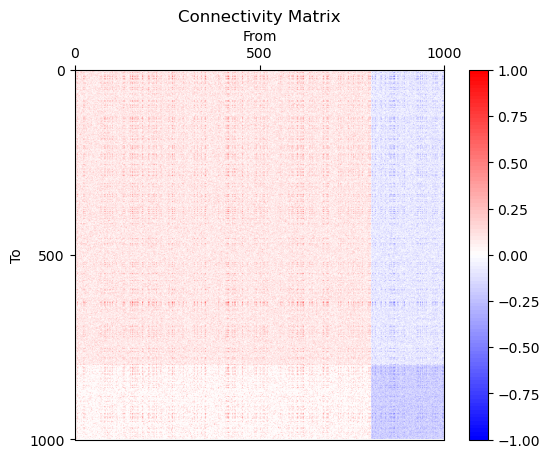

In [20]:
# Show the Network information before simulaiton

LRSNN.show()
LRSNN.show_conn(maxvalue=torch.max(LRSNN.conn)) #这里也许也可以优化一下


In [21]:
T = T_pre+T_sti+T_after # length of Period time (ms）


Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)

# Start Simulation
Out_go, V_go, g_go, spk_step_go, spk_ind_go = LRSNN(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_step_nogo, spk_ind_nogo = LRSNN(dt,Input_nogo)

Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [22]:

prop = torch.max(Out_go)/torch.max(Out_nogo)
print('Performance: ', prop.item())


Performance:  14.619298934936523


In [23]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
# spk_go = spk_go.cpu().numpy()
# spk_nogo = spk_nogo.cpu().numpy()
m = m.cpu().numpy()
n = n.cpu().numpy()
Sti_go = Sti_go.cpu().numpy()
Sti_nogo = Sti_nogo.cpu().numpy()

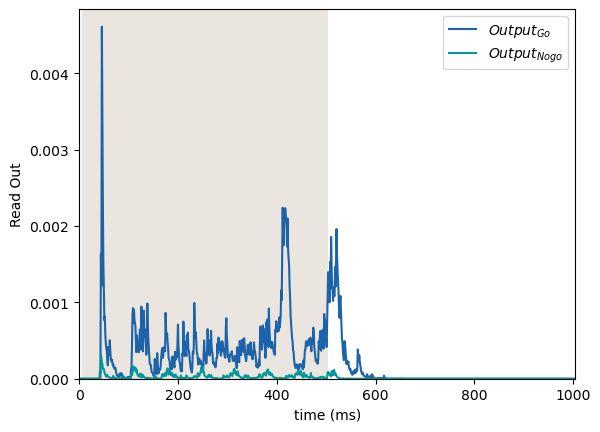

In [24]:

# Draw the results
# color_Go = '#1C63A9'
# color_Nogo = '#009999'

# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

0.4775808 0.5
0.06536851 0.5


TypeError: Draw_Conductance() got an unexpected keyword argument 'spectrum'

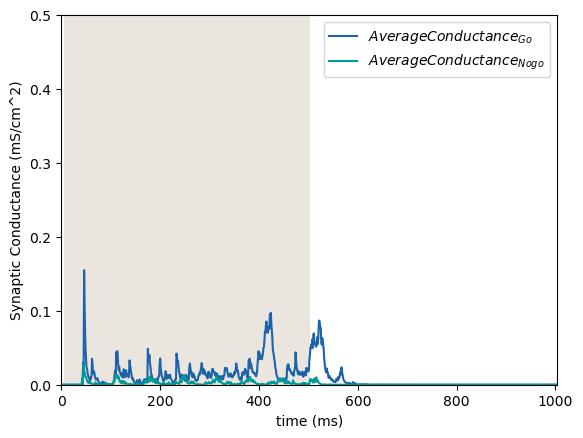

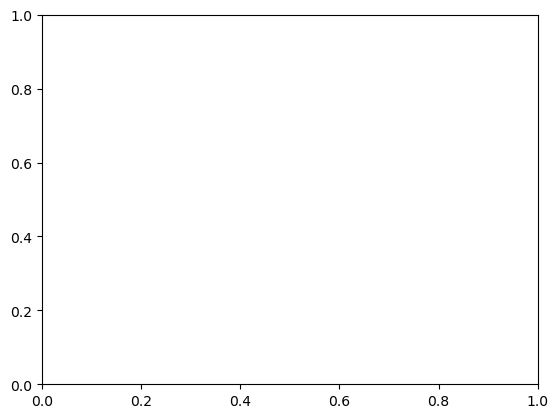

In [26]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.5])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.5])




In [164]:
# # Monitor the Voltage
# fig, ax = plt.subplots()
# Draw_Voltage(ax,V_go[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_go)
# Draw_Voltage(ax,V_go[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_go)
# fig, ax = plt.subplots()
# Draw_Voltage(ax,V_nogo[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_nogo)
# Draw_Voltage(ax,V_nogo[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_nogo)

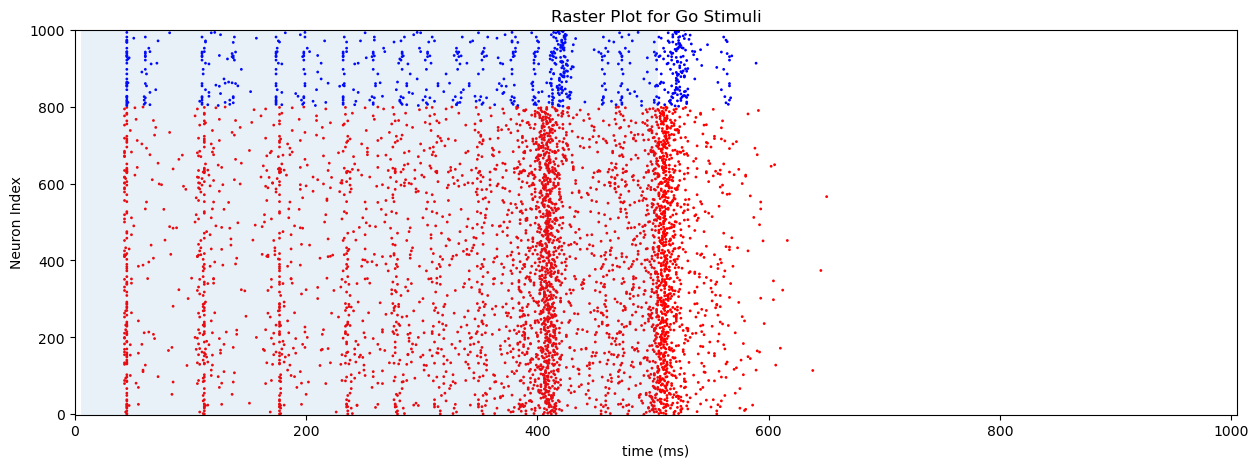

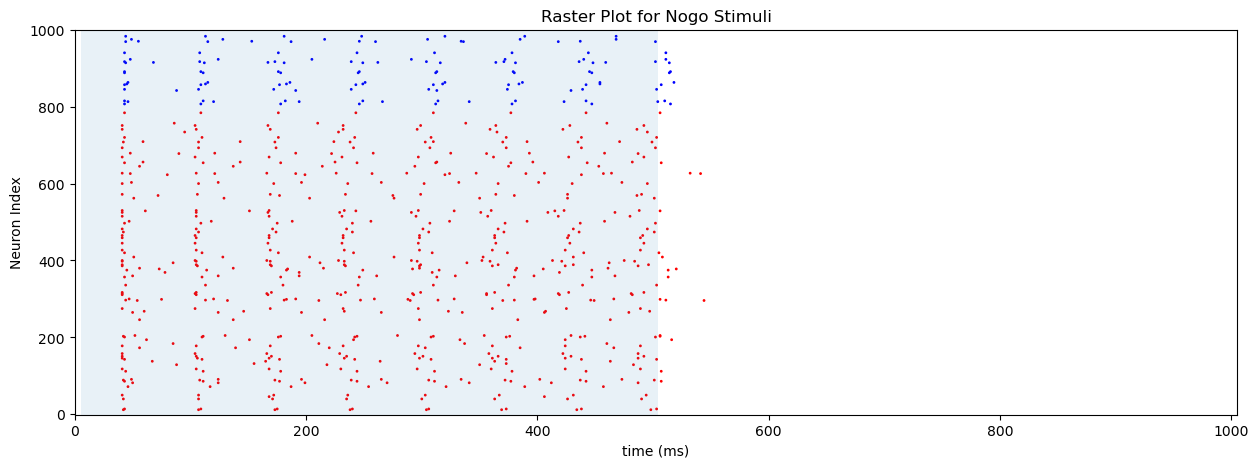

In [27]:
# Raster Plot
fig, ax = plt.subplots(figsize=(15,5))
Draw_RasterPlot(ax,spk_step_go, spk_ind_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots(figsize=(15,5))
Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

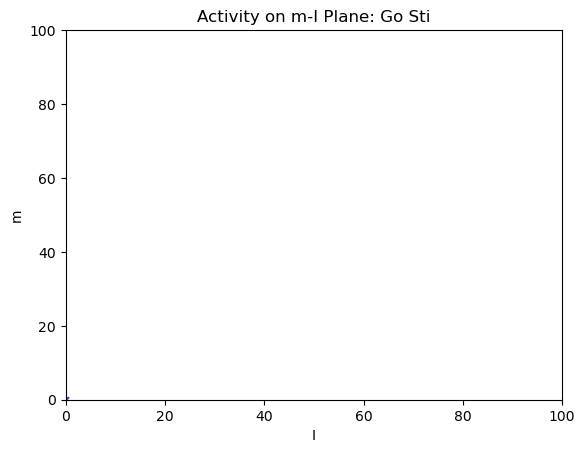

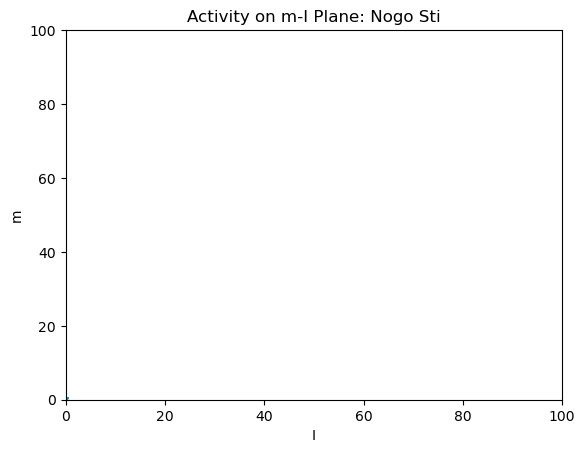

In [122]:
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.squeeze().T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,100],xlim=[0,100])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.squeeze().T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,100],xlim=[0,100])

In [25]:
# 保存模型
save_model(LRSNN,dt,Sti_go,Sti_nogo,Input_go,Input_nogo,IS,m,n)

In [36]:
# 将兴奋性神经元改为抑制性神经元
# 导入网络

# model = torch.load('/SanDisk/Li/LowRank_ModifiedTheta_SNN/PYTHON/models/2024_03_02_07_56.pth')
# LRSNN = model['model']
# Input_go = model['Input_go'].cpu()
# Input_nogo = model['Input_nogo'].cpu()
# dt = model['dt']
# Sti_go = model['Sti_go']
# Sti_nogo = model['Sti_nogo']
# Input_go = model['Input_go']
# Input_nogo = model['Input_nogo']
# m = model['m']
# n = model['n']

LRSNN.N_E = torch.tensor(4000)
LRSNN.N_I = torch.tensor(1000)

Input_go = torch.tensor(Input_go)
Input_nogo = torch.tensor(Input_nogo)

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)

# Start Simulation
Out_go, V_go, g_go, spk_go = LRSNN(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN(dt,Input_nogo)




Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


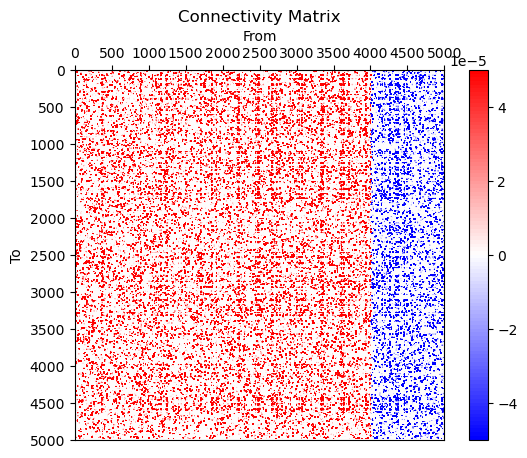

In [37]:
LRSNN.show_conn(maxvalue=0.00005)


In [ ]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()
Sti_go = Sti_go.cpu().numpy()
Sti_nogo = Sti_nogo.cpu().numpy()

In [42]:
# perf = torch.max(Out_go)/torch.max(Out_nogo)
perf = np.max(Out_go)/np.max(Out_nogo)
print('Performance: ', perf.item())

Performance:  18623.693359375


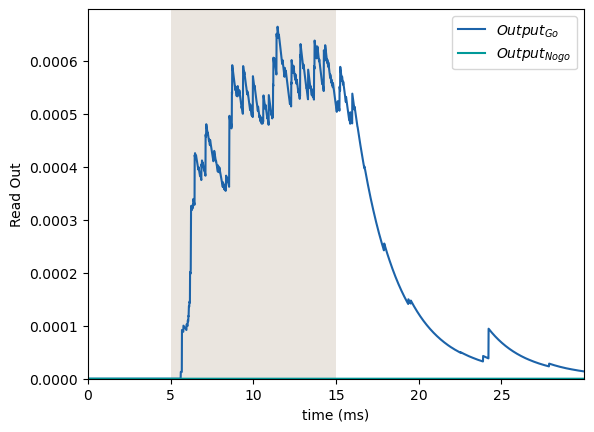

In [40]:

# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

0.0035134824 0.00025
0.00033061326 1e-05


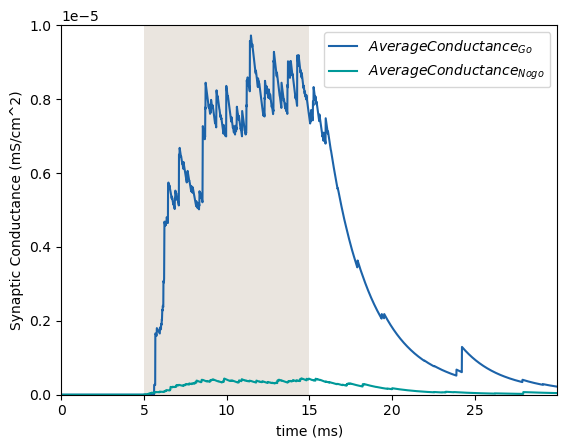

In [44]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.00025])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.00001])

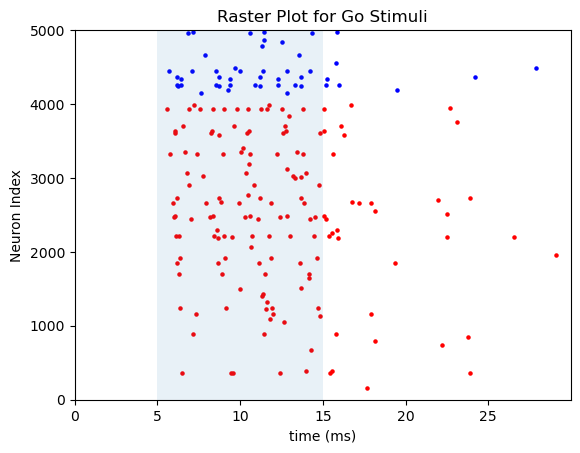

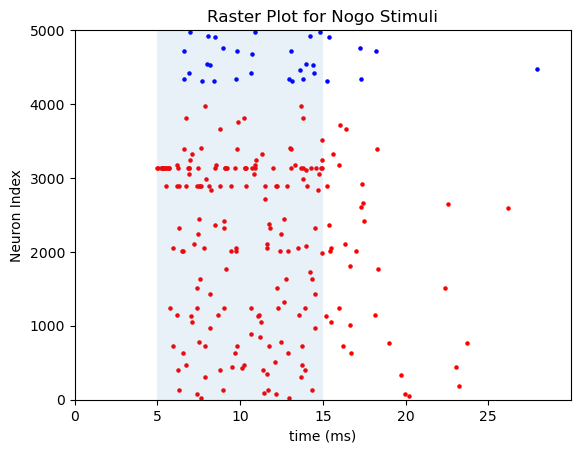

In [45]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

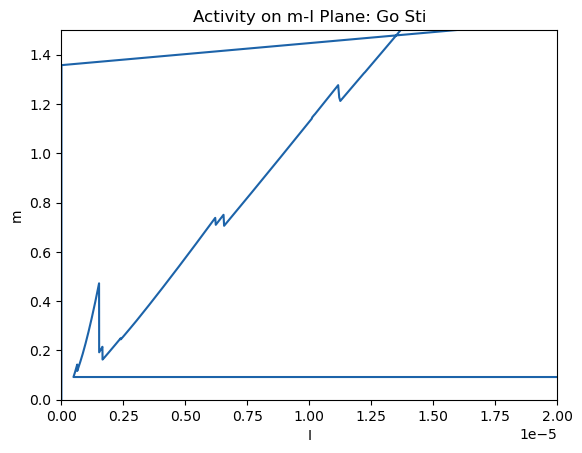

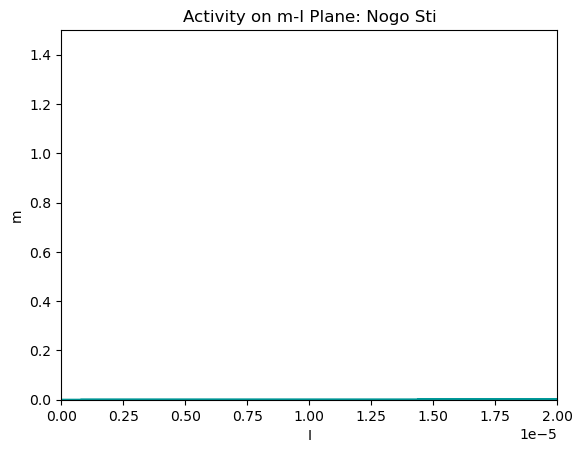

In [46]:
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,1.5],xlim=[0,0.00002])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,1.5],xlim=[0,0.00002])

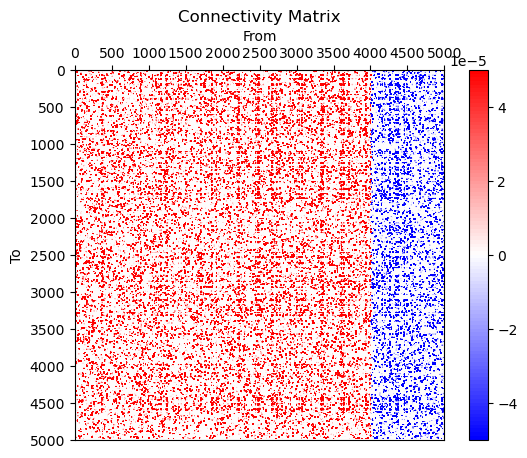

In [55]:
# 引入对synaptic decay time 的限制

# 导入3/5号之后的一个网络
model = torch.load('/SanDisk/Li/LowRank_ModifiedTheta_SNN/PYTHON/models/2024_03_05_08_56.pth')
#将tau_E和tau_I都改为100做测试
LRSNN = model['model']
# Input_go = model['Input_go']
# Input_nogo = model['Input_nogo']
Sti_go = torch.tensor(model['Sti_go'])
Sti_nogo = torch.tensor(model['Sti_nogo'])
dt = model['dt']
# 改变N_E和N_I
LRSNN.N_E = torch.tensor(4000)
LRSNN.N_I = torch.tensor(1000)
# 为了延长模拟时间，改变dt
dt = 0.1 #(ms/step)
T_pre = 5 # length of time before sti (ms)
T_sti = 10 # length of time for sti (ms)
# T_sti = 20 # length of time for sti (ms)
# T_after = 15 # length of time after sti (ms)
# T_after = 80 # length of time after sti (ms)
# T_after = 480 # length of time after sti (ms)
T_after = 975 # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms
IS = model['IS'] #Input Strength
# IS = 1 #Input Strength
Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go.T
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo.T

# print(Input_go.device)

# #延长刺激时间到1000ms
# # T_perlong = 70 # ms 
# T_perlong = 970 # ms 
# Input_perlong = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T_perlong/dt)))
# Input_go = torch.cat((Input_go,Input_perlong),dim=1)
# Input_nogo = torch.cat((Input_nogo,Input_perlong),dim=1)

LRSNN.show_conn(maxvalue=0.00005)
#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)


In [56]:

# 测试原来的仅有fast的结果
# dt = 10
# Start Simulation
Out_go, V_go, g_go, spk_go = LRSNN(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN(dt,Input_nogo)


Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [57]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()
# m = m.cpu().numpy()
# n = n.cpu().numpy()
# Sti_go = Sti_go.cpu().numpy()
# Sti_nogo = Sti_nogo.cpu().numpy()

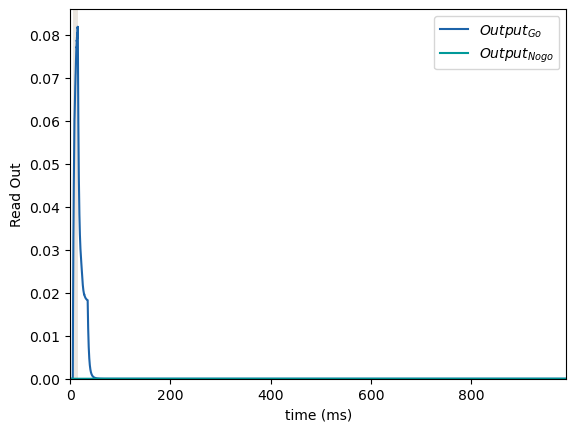

In [58]:

# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

0.49065563 5e-06
0.01420769 0.002


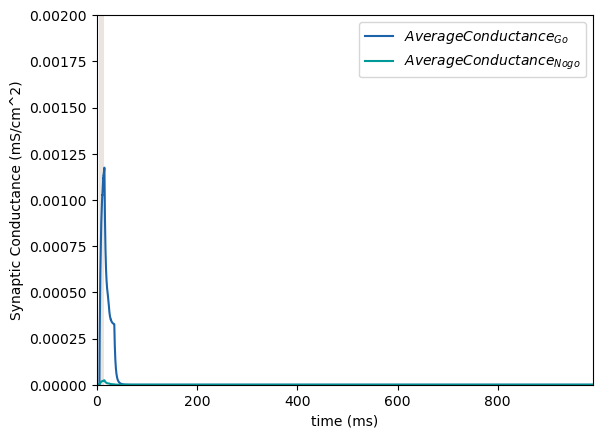

In [63]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.000005])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.002])

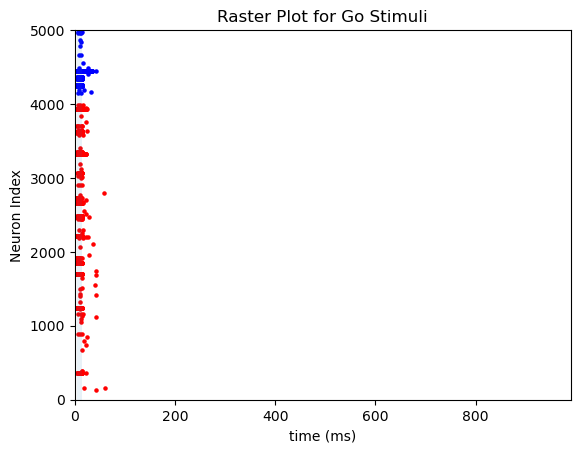

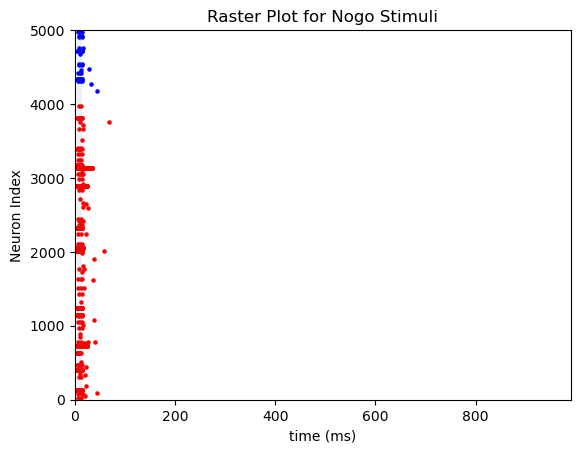

In [64]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

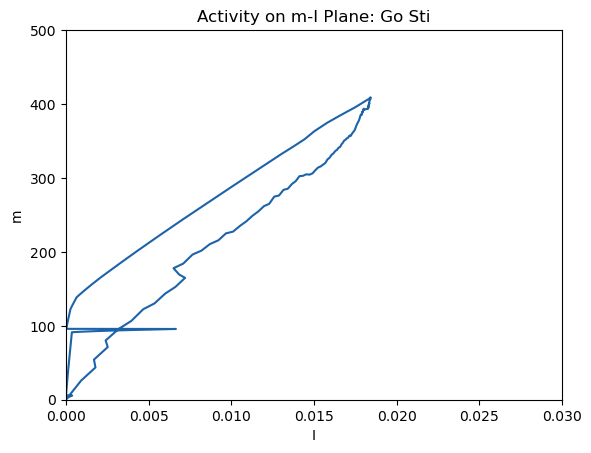

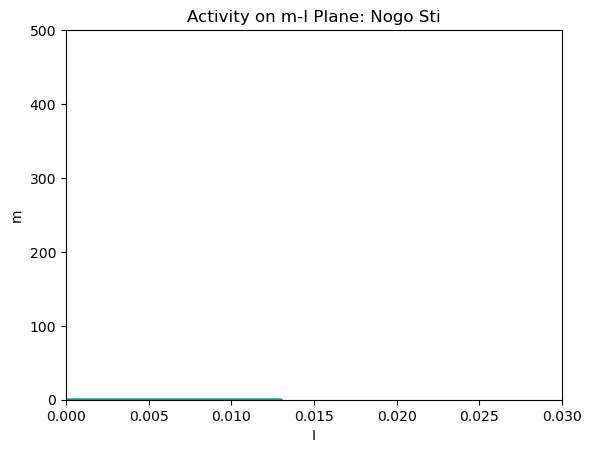

In [76]:
Sti_go = Input_go[:,int(6/dt)]
Sti_nogo = Input_nogo[:,int(6/dt)]
m = LRSNN.W_out.cpu().numpy()
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,500],xlim=[0,0.03])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,500],xlim=[0,0.03])

In [77]:
# 将synaptic decay time改为仅有slow
device = torch.device('cuda:0')
Input_go = torch.tensor(Input_go).to(device)
Input_nogo = torch.tensor(Input_nogo).to(device)
LRSNN_slow = LowRankSNN(N_E=4000,N_I=1000,RS= 1,taud_E=100,taud_I=100)
LRSNN_slow.conn = LRSNN.conn
LRSNN_slow.conn_lowrank = LRSNN.conn_lowrank
LRSNN_slow.conn_random = LRSNN.conn_random
LRSNN_slow.W_out = LRSNN.W_out
LRSNN = LRSNN.to(device)


In [78]:
# Start Simulation
Out_go, V_go, g_go, spk_go = LRSNN_slow(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN_slow(dt,Input_nogo)


Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [79]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()

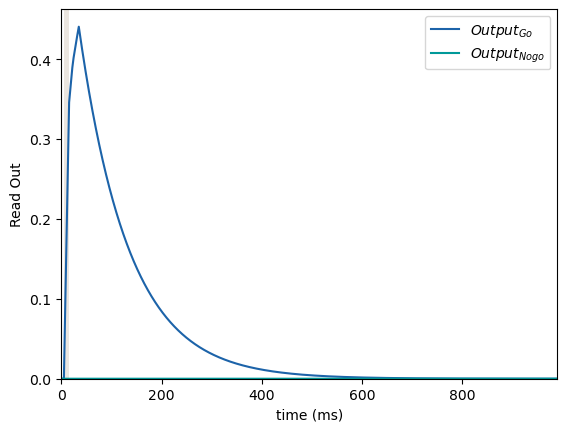

In [80]:

# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

1.7599277 0.002
0.073124535 0.02


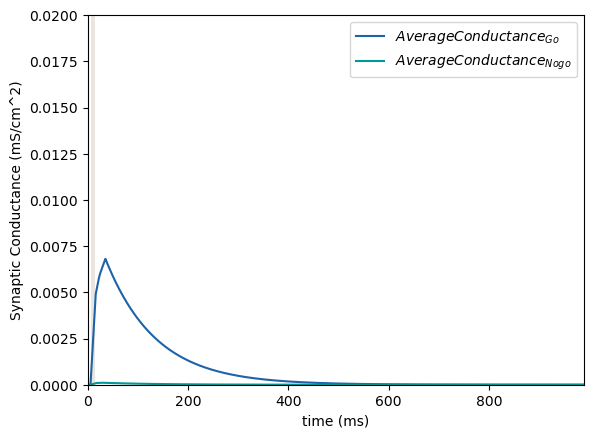

In [84]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.002])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.02])

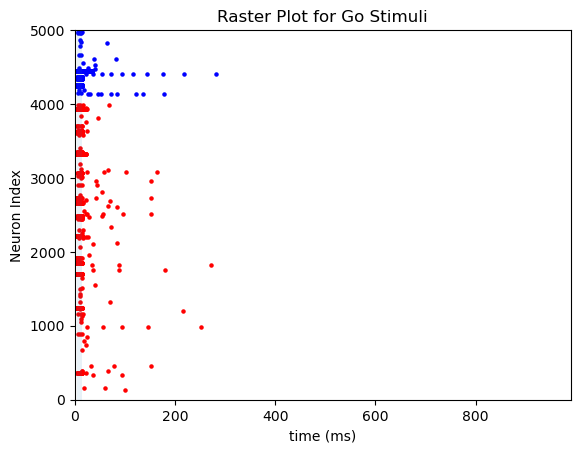

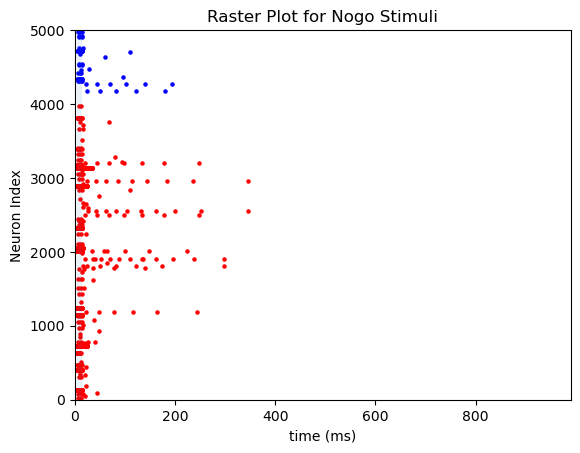

In [85]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

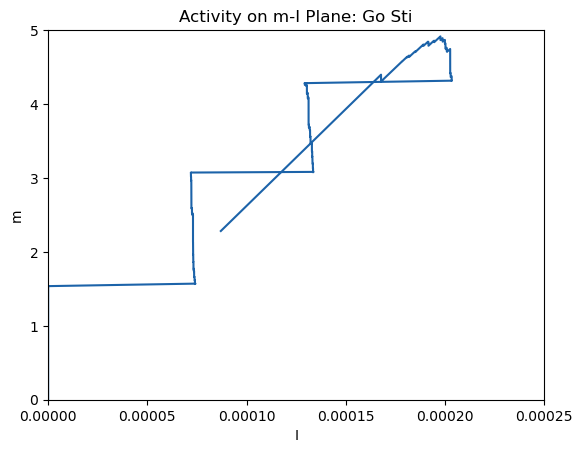

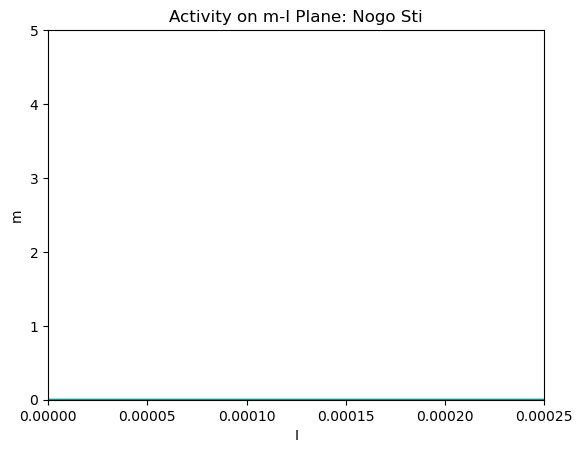

In [75]:
Sti_go = Input_go[:,int(6/dt)]
Sti_nogo = Input_nogo[:,int(6/dt)]
m = LRSNN.W_out.cpu().numpy()
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,5],xlim=[0,0.00025])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,5],xlim=[0,0.00025])